# Grover search

In this notebook we will follow the narrative set in the Bernstein-Vazirani computation (Deutch-Josza algorithm is its special case) and use oracle of similar form. Then we will use it to show that using quantum oracle helps us find *target element* faster. Since this is already quite expensive computation, we will do it only for very small "databases" with `2-5`qubits. This is not enough to show the quandratic speedup, but it is good enough to see the decrease in the number of steps that are necessary.

## Quantum oracle
We already know that quantum evolutions (and thus computation) has to be a reversible process. To be able to do that, it is enough to add additional system that will hold the computed information. Standard way of defining such quantum oracle is
$$ U_f|x\rangle\otimes|m\rangle = |x\rangle\otimes|m \oplus f(x)\rangle. $$
Where the second system is of appropriate dimension and $|m\rangle$ is some state of this system. Naturally, this oracle possesses no more information than $f$ does, but its ability to act on quantum systems (and superpositions in particular) makes the difference.

For boolean functions the second system is just an additional qubit. In many algorithms it is favorable to make the action of the oracle affect the phase (as phases are very good in eliminating unfavorable results) in front of selected states. Very often this desired action is
$$ R_f|x\rangle = (-1)^{f(x)}|x\rangle. $$
This does not seem to be much but when considering superpositions it has consequences. For example a single qubit identity function acting on states $|0\rangle$ or $|1\rangle$ does nothing (except adding a phase in front of $|1\rangle$) but it changes state $|+\rangle$ to $|-\rangle$. Indeed
$$ R_f\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) = \frac{1}{\sqrt{2}}\left[(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle\right]
=\frac{1}{\sqrt{2}}(|0\rangle -|1\rangle) = |-\rangle.$$

How to achieve this functioning of the quantum oracle $R_f$ using the quantum oracle $U_f$? It is simple when you start with $|m\rangle = |-\rangle$.

*Note: Feel free to try also larger parameters, but be aware of the fact that for the sake of clarity we do not do here any optimization and so your computations might (and will) run longer.*

In [1]:
import qiskit
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt
from random import randint
from math import pi, sqrt, acos, sin, inf
import numpy as np

## Feel free to change the dimension.
dim = 5

## You can use qreg and creg as global variables
## One qubit is reserved for the oracle as the ancilla (please use the last qubit for this purpose)
qreg = qiskit.QuantumRegister(dim + 1)
creg = qiskit.ClassicalRegister(dim)

simulator = qiskit.Aer.get_backend("qasm_simulator")
statevector = qiskit.Aer.get_backend('statevector_simulator')

Before going further let us define few useful transformation functions:

In [2]:
def bin_str(num, dim=0):
    """
    Returns binary representation of num (int) as a string with optional
    parameter dim to fill with zeroes from left up to length dim.
    """
    return f"{num:0{dim}b}"

def bin_digits(num, dim=0):
    """
    Returns binary representation of num (int) as a list of ints with optional
    parameter dim to fill with zeroes from left up to length dim.
    """
    return [int(c) for c in bin_str(num, dim)]

## The oracle

The oracle will be defined similarly to the one in Bernstein-Vazirani algorithm. This time our requirements from the oracle are that it marks only a **single** target. The `target` element can be passed either as a parameter during initialization, or will be chosen randomly. We will have four methods, two of them resetting the attributes `ccalls` and `qcalls` collecting number of times the classical and quantum oracles have been called (these are only for our convenience).

For the retrieval of classical oracle call, you can use the `get` method, which returns evaluated $f(x)$ for input `x`. For the quantum oracle the method `qoracle` returns quantum circuit of the oracle (as a black box). The method has an optional switch `ancilla_minus` which determines whether state $|-\rangle$ should be used on the ancilla (phase inducing oracle) or, if it is `False` it leaves the ancilla in the initial state $|0\rangle$ which can be used if we want to check whether we have found correct result (this setting simulates classical oracle). This is necessary, as Grover oracle, unlike Bernstein-Vazirani algorithm, does not give 100% succes rate, and so we need to check whether we got the correct result.

**Task 1:** Fill in the code for the quantum oracle based on the specification from above: it should mark single element `target`. To do this, use Qiskit circuit method `mcx(<list of ctrl qubits>, <target qubit>)` which implements a multi-qubit controlled `NOT`. For example `circuit.mcx([1, 2, 3], 0)` flips the 0-th qubit if all qubits 1, 2, and 3 are in state $|1\rangle$. Do not forget to undo any changes that you make at the beginning of the circuit.

In [3]:
class oracle:
    """
    Implements Grover oracle with single marked entry
    
    Attributes
    ----------
    dim: int
        number of (qu)bits that are used
    ccalls: int
        number of calls performed on the classical oracle
    qcalls: int
        number of calls performed on the quantum oracle
        
    Methods
    -------
    get(x)
        returns f(x)
    qoracle(qreg)
        returns the oracle circuit on qreg
    creset()
        resets the count of ccalls
    qreset()
        resets the count of qcalls
    """
    
    def __init__(self, dim, target=None):
        """
        Parameters
        ----------
        dim: int
            number of (qu)bits that are used
        num: Optional[int]
            initializes the target
        """
        if target == None:
            target = randint(0, 2 ** dim - 1)
        ## Private attribute only God knows
        self._target = target
        self.dim = dim
        self.ccalls = 0
        self.qcalls = 0
        
    def get(self, x):
        """
        returns f(x)
        
        Parameters
        ----------
        x: str
            evaluated input value for the f(x)
        """
        assert len(x) == self.dim
        ## ccalls increases every time one queries the oracle
        self.ccalls += 1
        s = bin_digits(self._target, self.dim)
        return x == s
    
    ## Assuming that when one calls the qoracle to be created
    ## dim is correctly stated
    def qoracle(self, qreg, ancilla_minus=True):
        """
        returns Qiskit circuit representing quantum oracle
        
        Parameters
        ----------
        qreg:
            qiskit quantum register
        """
        
        ## qcalls increases every time one queries the oracle
        self.qcalls += 1
        oracle = qiskit.QuantumCircuit(qreg)
        
        ## Fill here the code for Grover oracle circuit
        ## It should contain following parts:
        ##  - preparation of ancilla conditioned on ancilla_minus
        ##    (if True, prepare |-> on ancilla, otherwise prepare |0> 
        ##    on ancilla, i.e. on the last qubit)
        if ancilla_minus:
            oracle.x(self.dim)
            oracle.h(self.dim)
        ##  - encode information about target into the oracle circuit
        ##    (i.e. make x gate on suitable selection of qubits, so that 
        ##    the computational basis state corresponding to _target is 
        ##    transfered to |111....> state)
        for idx, x in enumerate(bin_digits(self._target, self.dim)):
            if x == 0:
                oracle.x(self.dim - 1 - idx)
        ##  - perform multi-controlled NOT using mcx method
        oracle.mcx(list(range(self.dim)),self.dim)
        ##  - undo all previous "preparation" changes to keep the circuit clean for further uses
        ##    (i.e. undo previous changes (except for mcx gate) to achieve the required unitary 
        ##    action R_f of the quantum oracle )
        for idx, x in enumerate(bin_digits(self._target, self.dim)):
            if x == 0:
                oracle.x(self.dim - 1 - idx)
        
        if ancilla_minus:
            oracle.h(self.dim)
            oracle.x(self.dim)
            
        
        
     

        return oracle
    
    def creset(self):
        """
        resets the count of ccalls
        """
        self.ccalls = 0
        
    def qreset(self):
        """
        resets the count of qcalls
        """
        self.qcalls = 0

## Classical search

Let us start with the classical search first. The search is defined in the function `classical` which will be your task. It takes Grover oracle as input and returns `target` it finds.

**Task 2:** Program function `classical` that finds target element using only the `get` method of the oracle `gro` (class oracle) passed as a parameter. Remember, each call of the method increments `ccalls`, the number of times the classical oracle has bee queried. (Hint: Do systematic search through all the options)

In [4]:
def classical(gro):
    ## Write your code here
    for i in range(2 ** gro.dim):
        if gro.get(bin_digits(i, gro.dim)):
            return i

 

The code below evaluates your function classical and provides test of the correctness. You should be able to correctly find all targets with the average number of steps being $\frac{1}{2}(2^d+1)$, where $d$ is the dimension `dim`.

In [5]:
runs = 1000
correct = 0
calls = 0

for _ in range(runs):
    gro = oracle(dim)
    if classical(gro) == gro._target:
        correct += 1
    calls += gro.ccalls

print(f"You correctly guessed the target in {100 * correct / runs:.1f}% of runs")
print(f"The average number of oracle calls was {calls / runs:.2f}")
print(f"Theoretical expected number of oracle calls is {(2 ** gro.dim + 1) / 2:.2f}")

You correctly guessed the target in 100.0% of runs
The average number of oracle calls was 16.42
Theoretical expected number of oracle calls is 16.50


## Grover search

Grover search finds the target element quadratically faster as the classical search. The speed is counted in the number of oracle calls, which we have already prepared.

The algorithm is as follows:
1. Prepare the initial state on the qubit register (without ancilla) as equal superposition,
2. Repeat `steps` times:
   1. Apply the quantum oracle
   2. Apply inversion about average
3. Measure the register

The algorithm gives you one guess for a target, which might not be correct. We will later implement ways of correctly identifying the target, but for now let us concentrate on single run of Grover algorithm. This will require defining the inversion about average first.

### Inversion about average

Inversion about average is an operation that is an essential step in Grover algorithm that helps increasing desired amplitudes while decreasing unwanted ones. Its prescription is $2|s\rangle\langle s| - \mathbb 1$, where $|s\rangle$ is the state of equal superposition. However, we will use $G=\mathbb 1 - 2|s\rangle\langle s|$ which introduces only a general phase flip, since it is easier to implement.

Let us analyze this operation to see how it can be implemented. Firstly, we know that $|s\rangle = H^{\otimes d}|0\rangle$, where $|0\rangle$ is the zero-th state of the computational basis (all zeros). Then using the fact that $H^2 = \mathbb 1$ we rewrite
$$
G = \mathbb 1 - 2|s\rangle\langle s| = H^{\otimes d}H^{\otimes d}-2H^{\otimes d}|0\rangle\langle 0|H^{\otimes d} = H^{\otimes d} (\mathbb 1 - 2|0\rangle\langle 0|) H^{\otimes d}.
$$
From this we see, that `G` can be implemented by changing the base to the Hadamard, then performing the flipping operation, and then reverting back to the computational basis. The flipping part should pose no problems now, as it is very similar to the Grover oracle for which the `target` is 0.

**Task 3:** Provide code for the function `G` implementing inversion about average. The function returns the circuit for the operation which is described above.

In [6]:
def G(dim):
    circ = qiskit.QuantumCircuit(qreg)
    
    ## Write your code here. It should contain
    ## - preparation of state |-> on the ancilla
    circ.x(dim) 
    circ.h(dim)
    ## - change of base (all qubits except ancilla)
    for i in range(dim):
        circ.h(i)
        circ.x(i)
    ## - implementation of the flip (mcx gate) on the 0 state
    circ.mcx(list(range(dim)),dim)
    ##   (write it explicitly, do not use the Grover oracle)
    ## - cleaning of the circuit by reverting the
    ##   performed changes
    
    
    for i in range(dim):
        circ.x(i)
        circ.h(i)
        
    circ.h(dim)
    circ.x(dim)

    return circ

You can see the operation here.

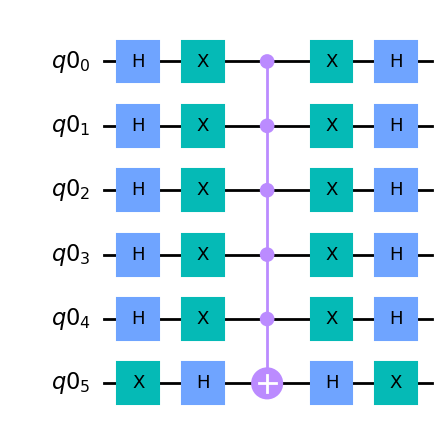

In [7]:
G(dim).draw(output="mpl")

We are ready now to implement Grover search.

**Task 4:** Following the steps from the description, implement Grover search. The parameters passed to the function are the Grover oracle `gro` and the number of `steps` that the algorithm should repeat.

In [8]:
def grover(gro, steps):
    circ = qiskit.QuantumCircuit(qreg, creg)

    ## Implement the Grover search. It should contain the following steps:
    ##  1. Initialization of the equal superposition
    for i in range(gro.dim):
        circ.h(i)
        
    circ.barrier()

    ##  2. Repeating steps times
    for j in range(steps):
        ## A. Application of the Grover oracle
        circ.extend(gro.qoracle(qreg))
        circ.barrier()
    
    
        ## B. Application of the inversion about average
        circ.extend(G(dim))
        circ.barrier()
    
    
    
    ##  3. Measurement of the register
    for i in range(gro.dim):
        circ.measure(i, i)

    job = qiskit.execute(circ, simulator, shots=1)
    return list(job.result().get_counts().keys())[0], circ

C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg))
C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:19: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(G(dim))


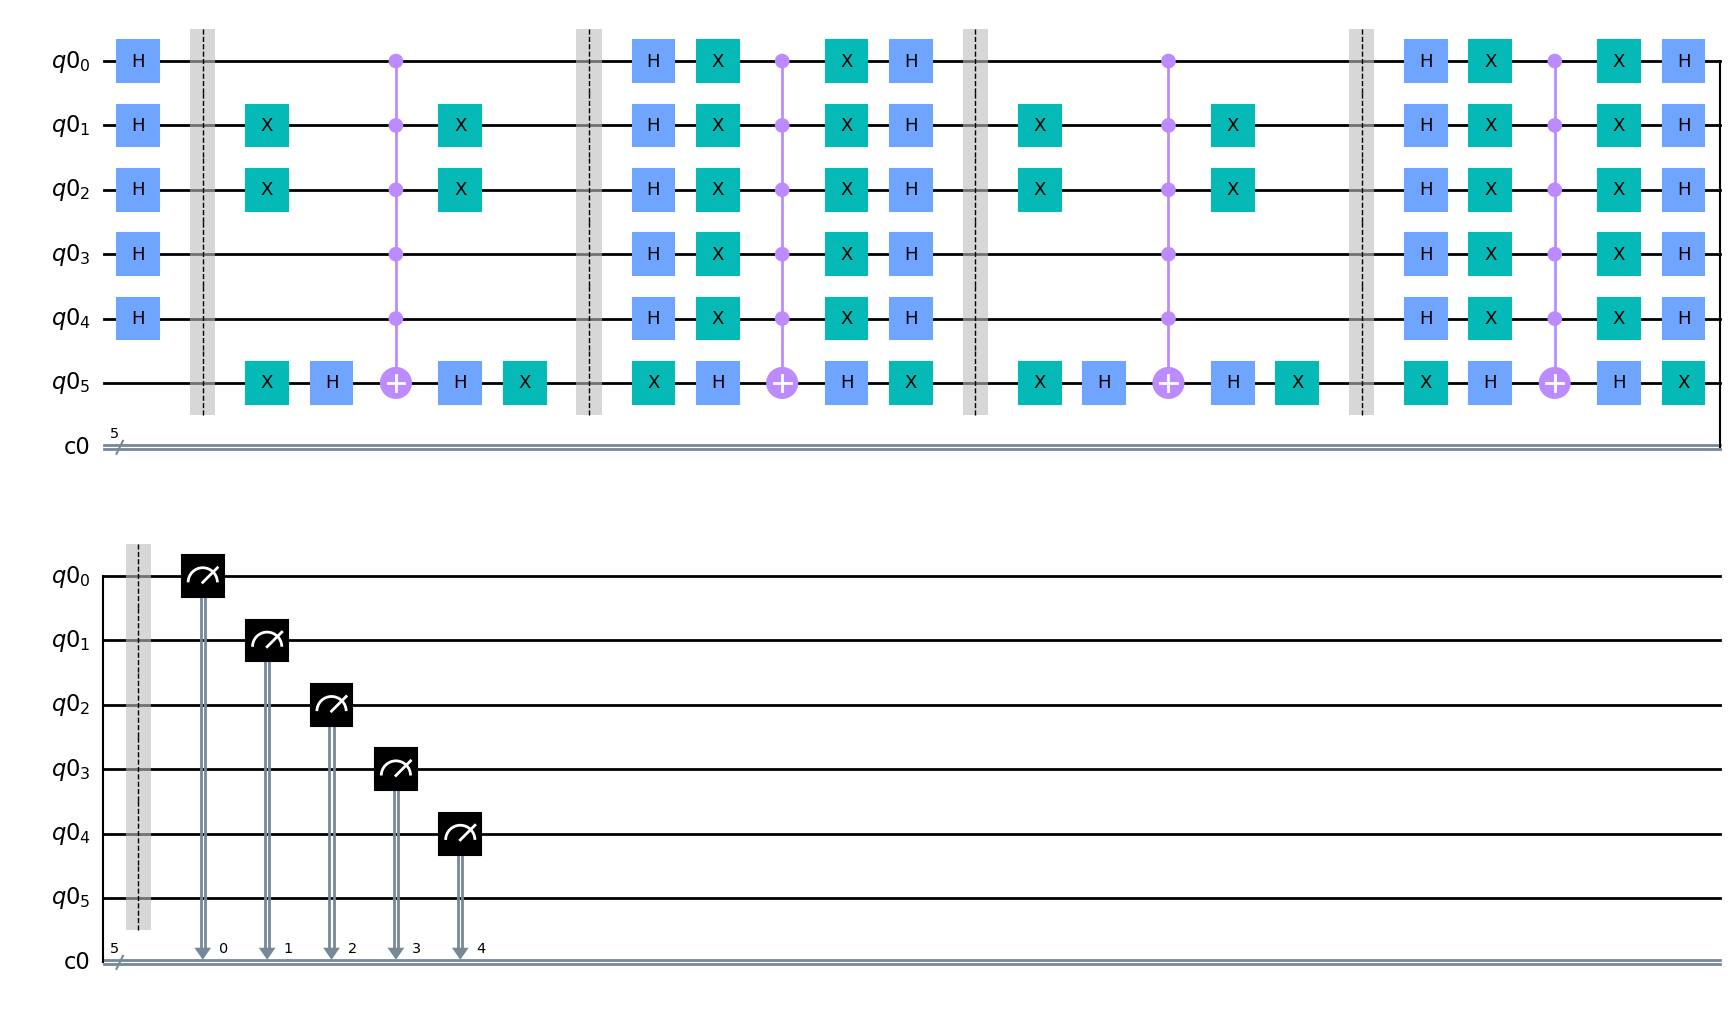

In [9]:
grover(oracle(dim), 2)[1].draw(output="mpl")

Let us first see what the circuit does for different inputs of `steps`.

For reference, but unknown to us, the target is 5 in decimal, or in binary 00101


C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg))
C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:19: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(G(dim))


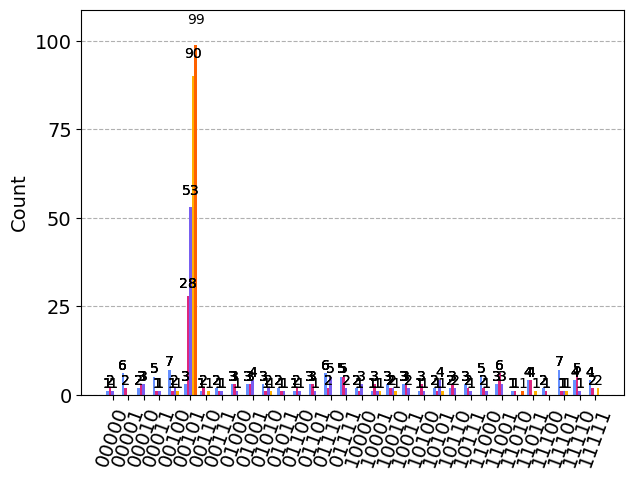

In [10]:
runs = 100
gather = []
maxsteps = dim

gro = oracle(dim)
print(f"For reference, but unknown to us, the target is {gro._target} in decimal, or in binary {bin_str(gro._target, dim)}")

for step in range(maxsteps):
    out = {}
    for run in range(runs):
        res, circ = grover(gro, step)
        out[res] = out.get(res, 0) + 1
    gather.append(out)
    
plot_histogram(gather)

You should be able to see one output showing high probability of being detected. If you have done everything correctly, this output should coincide with the `target`.

### Finding the target

Previous computation has led to many results, which were not always the target. Yet the probability of finding the target is reasonably higher than for any other output and so few repetitions should suffice to lead us to a conclusive result. This will be your task in this last part.

First, you can play with choosing different numbers of steps to see how the probability behaves with the number of oracle calls.

In [11]:
runs = 1000
steps = 3
correct = 0
calls = 0

for _ in range(runs):
    gro = oracle(dim)
    if grover(gro, steps)[0] == bin_str(gro._target, dim):
        correct += 1
    calls += gro.qcalls

print(f"You correctly guessed the target in {100 * correct / runs:.1f}% of runs")
theta = acos(1 - 1 / 2 ** (dim - 1))
print(f"Theoretical probability is {100 * sin((2 * steps + 1) * theta / 2) ** 2:.1f}")
print(f"The average number of oracle calls was {calls / runs:.2f}")
print(f"The probability should be maximal with number of steps close to {(pi / theta - 1) / 2:.2f}")
print(f"Theoretical expected number of classical oracle calls is {(2 ** gro.dim + 1) / 2:.2f} [for comparison]")

C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg))
C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:19: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(G(dim))


You correctly guessed the target in 89.4% of runs
Theoretical probability is 89.7
The average number of oracle calls was 3.00
The probability should be maximal with number of steps close to 3.92
Theoretical expected number of classical oracle calls is 16.50 [for comparison]


You can see your observations in one figure, where we evaluate Grover search for different values of `steps`. For the number of steps close to the optimal, the probability indeed aproaches 100%, though reaching it is rarely possible (and depends on the `dim`). In the figure you can compare your simulated probabilities (blue) with the theoretical prediction (dashed gray).

C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg))
C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:19: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(G(dim))


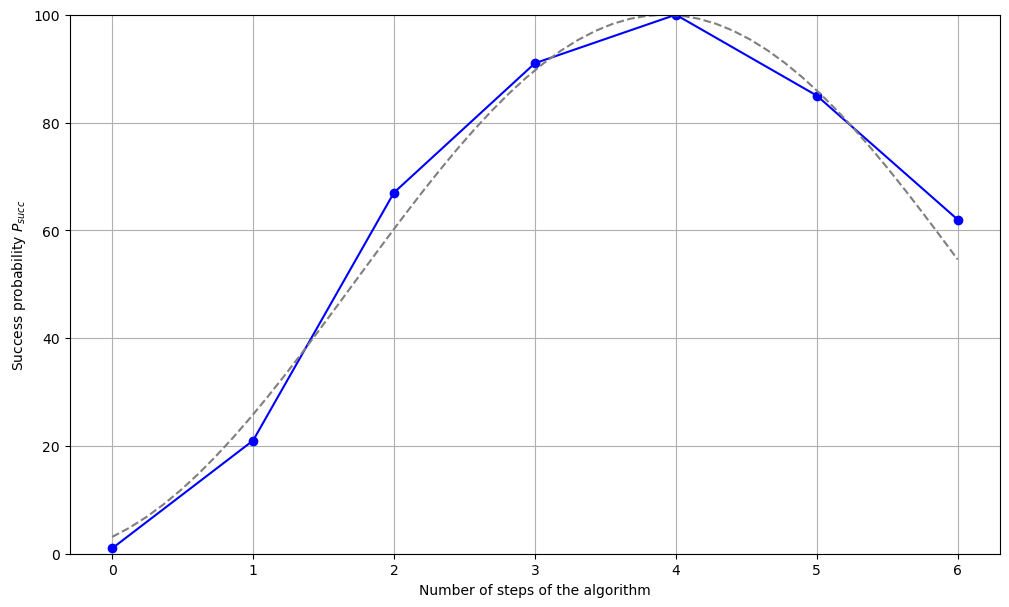

In [12]:
maxsteps = 7
runs = 100

probs = {}
for step in range(maxsteps):
    correct = 0
    for _ in range(runs):
        gro = oracle(dim)
        if grover(gro, step)[0] == bin_str(gro._target, dim):
            correct += 1
    probs.update({step: 100 * correct / runs})

plt.rcParams["figure.figsize"] = 12, 7
plt.ylabel("Success probability $P_{succ}$")
plt.xlabel("Number of steps of the algorithm")
plt.grid(True)
plt.ylim(0, 100)
plt.plot(list(probs.keys()), list(probs.values()), "bo-")
plt.plot(np.linspace(0, 6, 50), [100 * sin((2 * x + 1) * theta / 2) **2 for x in np.linspace(0, 6, 50)], "C7--")

Now, you should provide a code for an algorithm that evaluates Grover search until it finds the target. To check whether your guess is indeed a target, you will need to make a checking circuit from the oracle that will validate your guess. This you can do by taking the oracle without preparing state $|-\rangle$ on the ancilla (use switch `ancilla_minus=False` in the `qoracle`).

**Task 5:** Prepare a circuit checking whether your guess is the target. Use the quantum oracle in the setting that evaluates
$$
U_f|x\rangle\otimes|0\rangle = |x\rangle\otimes|f(x)\rangle,
$$
where $x$ is your `guess` (on the input as a decimal `int`) and $U_f$ is the `qoracle`.

In [13]:
def qcheck(gro, x):
    circ = qiskit.QuantumCircuit(qreg, qiskit.ClassicalRegister(1))
    
    

    ## Implement the evaluation of the oracle to the ancilla.
    ## Your circuit should contain:
    ##  - encoding of the input guess to the initial state of the quantum register
    for idx, x in enumerate(bin_digits(x, dim)):
        if x == 1:
            circ.x(dim - 1 - idx)
    ##  - application of the qoracle with ancilla in state |0>
    circ.barrier()
    circ.extend(gro.qoracle(qreg, ancilla_minus=False))
    ##  - readout from the ancilla
    circ.measure(dim, 0)









    job = qiskit.execute(circ, simulator, shots=1)
    return list(job.result().get_counts().keys())[0], circ

C:\Users\patri\AppData\Local\Temp\ipykernel_11192\225756709.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg, ancilla_minus=False))


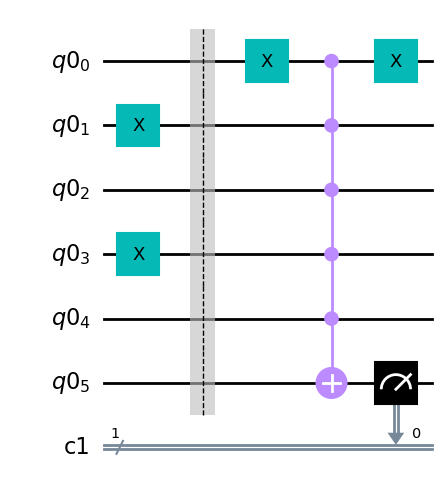

In [14]:
qcheck(gro, 10)[1].draw(output="mpl")

In [15]:
qcheck(gro, 10)

C:\Users\patri\AppData\Local\Temp\ipykernel_11192\225756709.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg, ancilla_minus=False))


('0', <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x184fd77a2e0>)

**Task 6:** The last function you need to program is the one, where you conclusively determine the `target`. Use previous function `qcheck` to check whether your guess is correct. Beware that it induces an additional call to the oracle and thus increments `qcalls`.

In [16]:
def qguess(gro, steps, maxiter=None):
    if not maxiter:
        limit = 1
    else:
        limit = maxiter
    res = None
    for i in range(limit):
        res = grover(gro, steps)[0]
        if qcheck(gro, int(res, 2))[0] == "1":
            return res
    return res
    

Again, let us look at particular choices of `steps` first.

In [17]:
runs = 1000
steps = 3
correct = 0
calls = 0

for _ in range(runs):
    gro = oracle(dim)
    guess = qguess(gro, steps)
    if guess == bin_str(gro._target, dim):
        correct += 1
    calls += gro.qcalls

print(f"You correctly guessed the target in {100 * correct / runs:.1f}% of runs")
theta = acos(1 - 1 / 2 ** (dim - 1))
psuc = sin((2 * steps + 1) * theta / 2) **2
print(f"The average number of oracle calls was {calls / runs:.2f}")
print(f"Theoretically predicted average number of steps is {(steps + 1) / psuc:.2f}")
print(f"Theoretical expected number of classical oracle calls is {(2 ** gro.dim + 1) / 2:.2f} [for comparison]")

C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg))
C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:19: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(G(dim))


You correctly guessed the target in 88.3% of runs
The average number of oracle calls was 4.00
Theoretically predicted average number of steps is 4.46
Theoretical expected number of classical oracle calls is 16.50 [for comparison]


You can observe that while we managed to obtain target with probability 100% (at least that is what you should get), the average number of oracle calls increased. The increase is, however, small enough to still beat the classical search easily. Again, we can compute this for the range of `steps` to see this dependence. As in the previous figure, the blue line represents simulated results, while the dashed grey one is the theoretical prediction.

*Note: be careful with the parameters, as the computation is already quite demanding.*

Computing for 0 steps...


C:\Users\patri\AppData\Local\Temp\ipykernel_11192\225756709.py:14: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(gro.qoracle(qreg, ancilla_minus=False))


Computing for 1 steps...


C:\Users\patri\AppData\Local\Temp\ipykernel_11192\1474358163.py:19: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ.extend(G(dim))


Computing for 2 steps...
Computing for 3 steps...
Computing for 4 steps...
Computing for 5 steps...


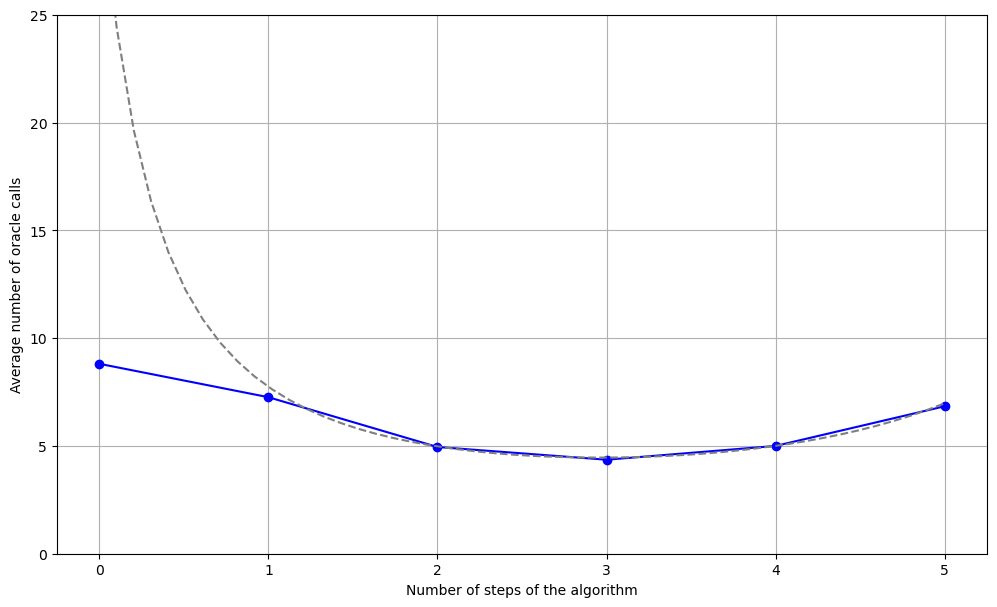

In [18]:
maxsteps = 5
runs = 100

calls = {}
for step in range(maxsteps + 1):
    print(f"Computing for {step} steps...")
    count = 0
    for _ in range(runs):
        gro = oracle(dim)
        guess = qguess(gro, step, 10)
        count += gro.qcalls
    calls.update({step: count / runs})
    
plt.rcParams["figure.figsize"] = 12, 7
plt.ylabel("Average number of oracle calls")
plt.xlabel("Number of steps of the algorithm")
plt.grid(True)
plt.ylim(0, 5 * dim)
plt.plot(list(calls.keys()), list(calls.values()), "bo-")
plt.plot(np.linspace(0, maxsteps, 50), \
         [(x + 1) / (sin((2 * x + 1) * theta / 2) **2) for x in np.linspace(0, maxsteps, 50)], "C7--")

You can notice that the optimal number of `steps` is lower than the number of `steps` for which we find the maximal success probability. This is because the decrease in the success probability for fewer steps is for a while more than compensated by the fewer steps performed each run.

Final note: we suggest exploring dimensions `2-5`. For larger dimensions, the computation becomes demanding. But also beware for smaller dimensions - the probability can decrease to a very small number and some computations may run for a very long times. You can include some threshold in the `qguess` function to limit the number of repetitions (and return `inf` in that case). These lower dimensions are also good to observe the periodic nature of the evolution.